### Camera Calibration with OpenCV
#### 1. Detecting Corners

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

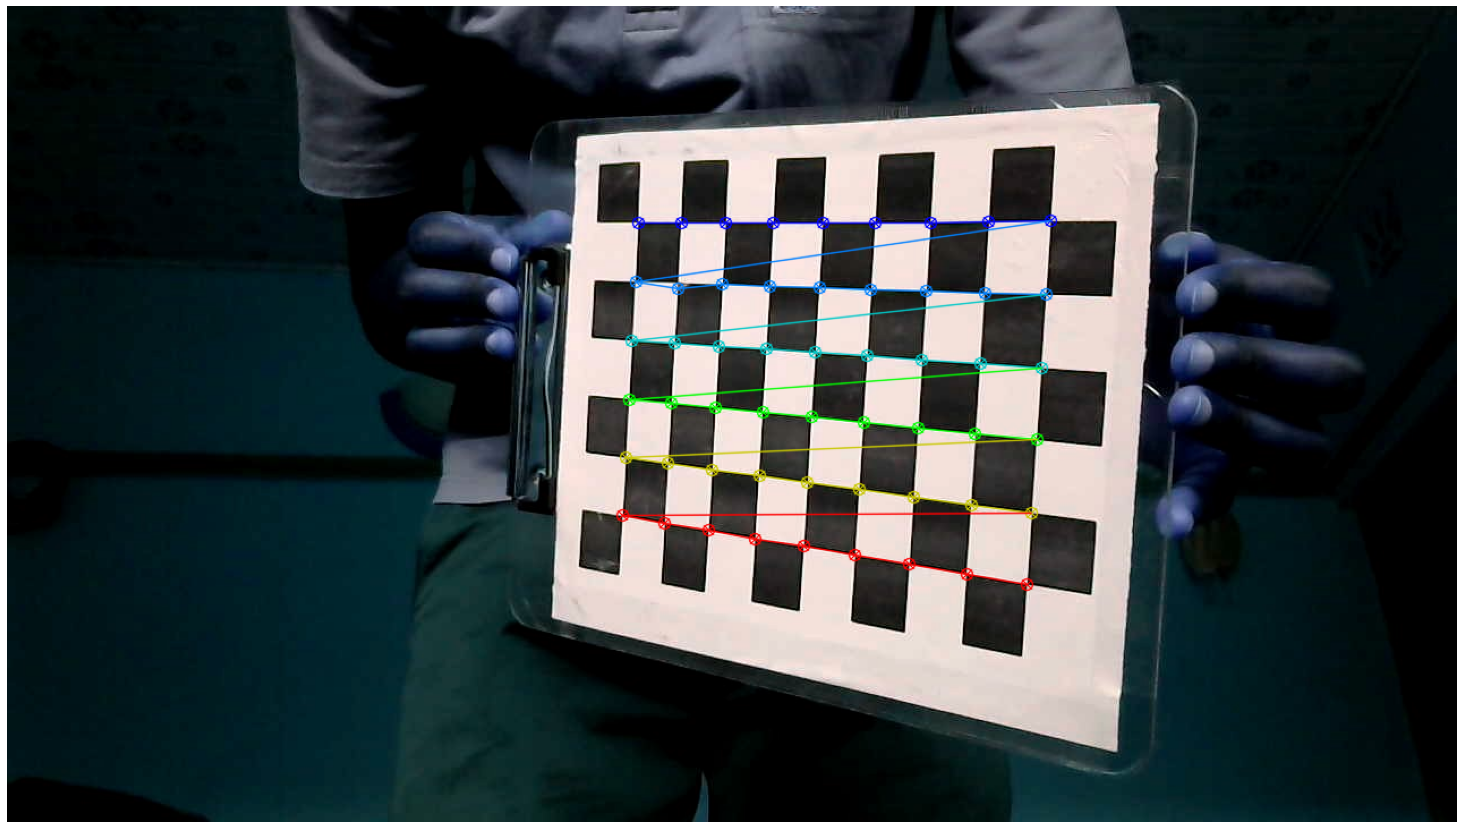

In [3]:
# prepare object points
nx = 9 #number on inside corners in x
ny = 6 #number of inside corners in y

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[0:54, 0:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3D coordinates in real world space
imgpoints = [] # 2D coordinates in image plane

# make list of calibration images
images = glob.glob('images/cam1/take5/*.jpg')

# for index, fname in enumerate(images):
img = cv2.imread(images[6])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# if found, draw the corners
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.figure(figsize=(30,15))
    plt.imshow(img), plt.axis('off')
    plt.show()
    # cv2.waitKey(500)

# cv2.destroyAllWindows()

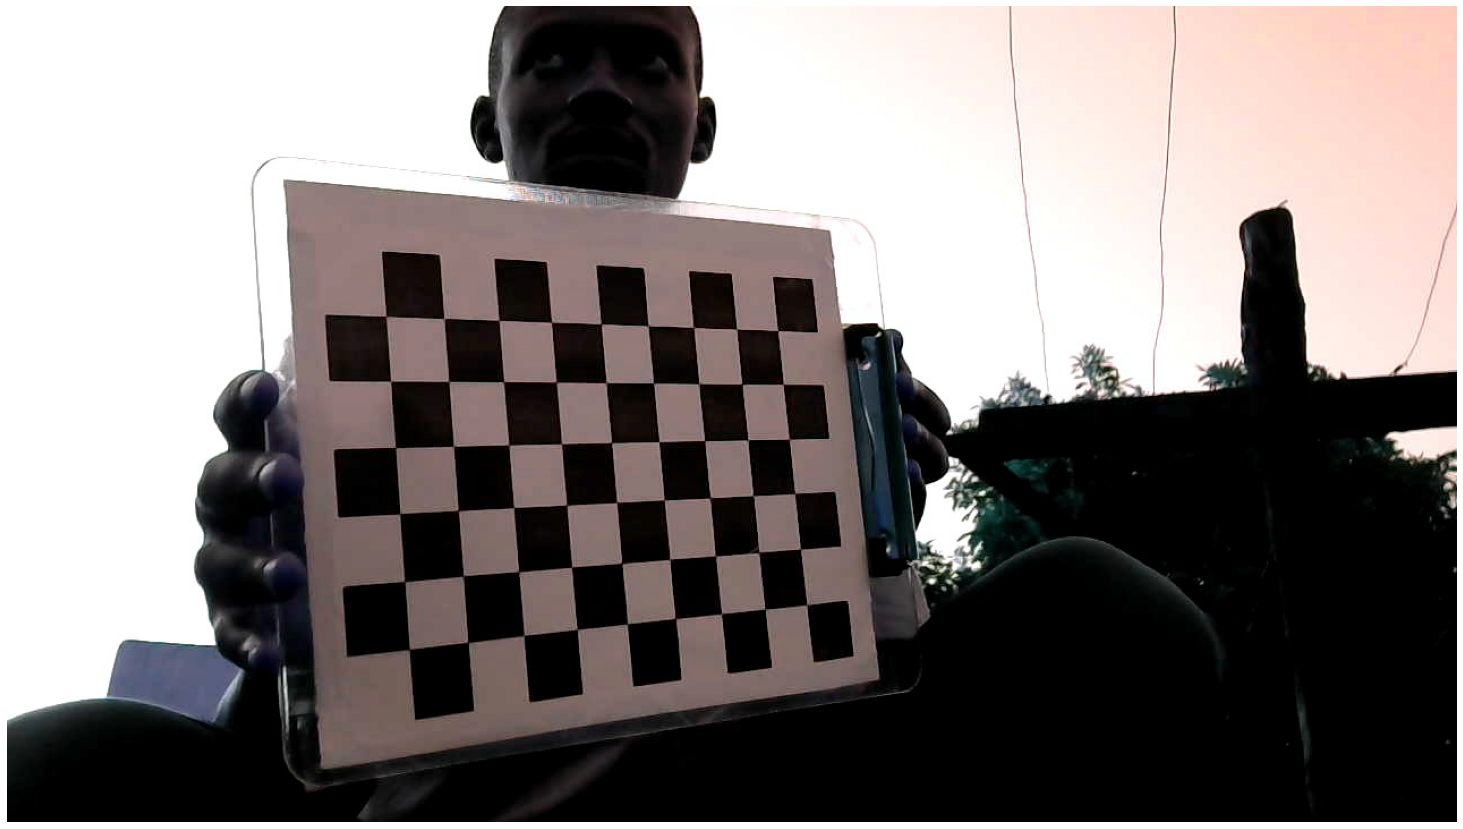

In [26]:
img = cv2.imread(images[16])
plt.figure(figsize=(30,15))
plt.imshow(img), plt.axis('off')
plt.show()

#### 2. Calibration

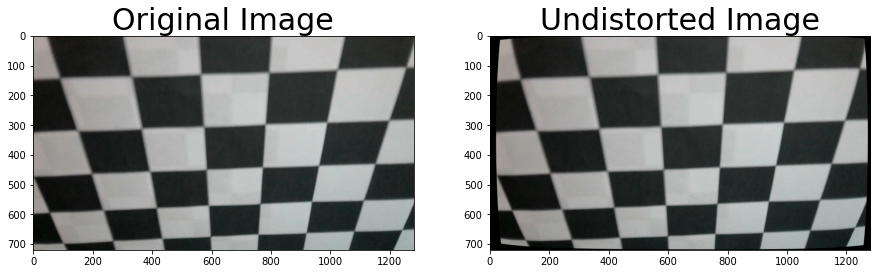

In [253]:
# test undistortion on an image
img = cv2.imread('calibration_images/dist.jpg')
img_size = (img.shape[0], img.shape[1])

# perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_images/undist.jpg', dst)

# save the camera calibration result for later use
dist_pickles = {}
dist_pickles["mtx"] = mtx
dist_pickles["dist"] = dist
pickle.dump(dist_pickles, open('calibration_images/dist_pickle.p', "wb"))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

In [268]:
mtx

array([[1.41877199e+03, 0.00000000e+00, 6.57321672e+02],
       [0.00000000e+00, 1.41752866e+03, 3.46187591e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### Double Calibration (Single and Stereo)

In [1]:
import glob
import os
import random
import sys
import numpy as np
import cv2

In [2]:
CHESSBOARD_SIZE = (6, 9)
# CHESSBOARD_SIZE = (9, 7)
CHESSBOARD_OPTIONS = (cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_FAST_CHECK)

OBJECT_POINT_ZERO = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)

OBJECT_POINT_ZERO[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

OPTIMIZE_ALPHA = 0.25

TERMINATION_CRITERIA = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

MAX_IMAGES = 64

In [3]:
def readImagesAndFindChessboards(imageDirectory):
    # cacheFile = "{0}/chessboards.npz".format(imageDirectory)
    # try:
    #     cache = np.load(cacheFile)
    #     print("Loading image data from cache file at {0}".format(cacheFile))
    #     return (list(cache["filenames"]), list(cache["objectPoints"]),
    #             list(cache["imagePoints"]), tuple(cache["imageSize"]))
    # except IOError:
    #     print("Cache file at {0} not found".format(cacheFile))

    print("Reading images at {0}".format(imageDirectory))
    imagePaths = glob.glob("{0}/*.png".format(imageDirectory))

    filenames = []
    objectPoints = []
    imagePoints = []
    imageSize = None

    for imagePath in sorted(imagePaths):
        image = cv2.imread(imagePath)
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        newSize = grayImage.shape[::-1]
        if imageSize != None and newSize != imageSize:
            raise ValueError(
                    "Calibration image at {0} is not the same size as the others"
                    .format(imagePath))
        imageSize = newSize

        hasCorners, corners = cv2.findChessboardCorners(grayImage,
                CHESSBOARD_SIZE, cv2.CALIB_CB_FAST_CHECK)

        if hasCorners:
            filenames.append(os.path.basename(imagePath))
            objectPoints.append(OBJECT_POINT_ZERO)
            cv2.cornerSubPix(grayImage, corners, (11, 11), (-1, -1),
                    TERMINATION_CRITERIA)
            imagePoints.append(corners)

        cv2.drawChessboardCorners(image, CHESSBOARD_SIZE, corners, hasCorners)
        cv2.imshow(imageDirectory, image)

        # Needed to draw the window
        cv2.waitKey(1)

    cv2.destroyWindow(imageDirectory)

    print("Found corners in {0} out of {1} images"
            .format(len(imagePoints), len(imagePaths)))

    np.savez_compressed('chessboards.npz',
            filenames=filenames, objectPoints=objectPoints,
            imagePoints=imagePoints, imageSize=imageSize)
    return filenames, objectPoints, imagePoints, imageSize

In [4]:
def getMatchingObjectAndImagePoints(requestedFilenames,
        allFilenames, objectPoints, imagePoints):
    requestedFilenameSet = set(requestedFilenames)
    requestedObjectPoints = []
    requestedImagePoints = []

    for index, filename in enumerate(allFilenames):
        if filename in requestedFilenameSet:
            requestedObjectPoints.append(objectPoints[index])
            requestedImagePoints.append(imagePoints[index])

    return requestedObjectPoints, requestedImagePoints

In [5]:
def main():
    if len(sys.argv) != 4:
        print("Syntax: {0} LEFT_IMAGE_DIR RIGHT_IMAGE_DIR OUTPUT_FILENAME".format(sys.argv[0]))
        sys.exit(1)

    leftImageDir = sys.argv[1]
    rightImageDir = sys.argv[2]
    outputFile = sys.argv[3]

    (leftFilenames, leftObjectPoints, leftImagePoints, leftSize) = readImagesAndFindChessboards(leftImageDir)
    (rightFilenames, rightObjectPoints, rightImagePoints, rightSize) = readImagesAndFindChessboards(rightImageDir)

    if leftSize != rightSize:
        print("Camera resolutions do not match")
        sys.exit(1)
    imageSize = leftSize

    filenames = leftFilenames + rightFilenames
    # filenames = list(set(leftFilenames) & set(rightFilenames))

    # if (len(filenames) > MAX_IMAGES):
    #     print("Too many images to calibrate, using {0} randomly selected images"
    #             .format(MAX_IMAGES))
    #     filenames = random.sample(filenames, MAX_IMAGES)
    # filenames = sorted(filenames)
    print("Using these images:")
    print(leftFilenames, rightFilenames)
    print(filenames)

    leftObjectPoints, leftImagePoints = getMatchingObjectAndImagePoints(filenames,
        leftFilenames, leftObjectPoints, leftImagePoints)
    rightObjectPoints, rightImagePoints = getMatchingObjectAndImagePoints(filenames,
            rightFilenames, rightObjectPoints, rightImagePoints)

    # TODO: Fix this validation
    # Keep getting "Use a.any() or a.all()" even though it's already used?!
    # if (leftObjectPoints != rightObjectPoints).all():
    #     print("Object points do not match")
    #     sys.exit(1)
    objectPoints = leftObjectPoints

    print("Calibrating left camera...")
    _, leftCameraMatrix, leftDistortionCoefficients, _, _ = cv2.calibrateCamera(
            objectPoints, leftImagePoints, imageSize, None, None)
    print(leftCameraMatrix)

    print("Calibrating right camera...")
    _, rightCameraMatrix, rightDistortionCoefficients, _, _ = cv2.calibrateCamera(
            objectPoints, rightImagePoints, imageSize, None, None)
    print(rightCameraMatrix)

    print("Calibrating cameras together...")
    (_, _, _, _, _, rotationMatrix, translationVector, _, _) = cv2.stereoCalibrate(
            objectPoints, leftImagePoints, rightImagePoints,
            leftCameraMatrix, leftDistortionCoefficients,
            rightCameraMatrix, rightDistortionCoefficients,
            imageSize, None, None, None, None,
            cv2.CALIB_FIX_INTRINSIC, TERMINATION_CRITERIA)
    print(translationVector)

    print("Rectifying cameras...")
    # TODO: Why do I care about the disparityToDepthMap?
    (leftRectification, rightRectification, leftProjection, rightProjection,
            dispartityToDepthMap, leftROI, rightROI) = cv2.stereoRectify(
                    leftCameraMatrix, leftDistortionCoefficients,
                    rightCameraMatrix, rightDistortionCoefficients,
                    imageSize, rotationMatrix, translationVector,
                    None, None, None, None, None,
                    cv2.CALIB_ZERO_DISPARITY, OPTIMIZE_ALPHA)
    print(leftROI, rightROI, dispartityToDepthMap)

    print("Saving calibration...")
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(
            leftCameraMatrix, leftDistortionCoefficients, leftRectification,
            leftProjection, imageSize, cv2.CV_32FC1)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(
            rightCameraMatrix, rightDistortionCoefficients, rightRectification,
            rightProjection, imageSize, cv2.CV_32FC1)

    np.savez_compressed(outputFile, imageSize=imageSize,
            leftMapX=leftMapX, leftMapY=leftMapY, leftROI=leftROI,
            rightMapX=rightMapX, rightMapY=rightMapY, rightROI=rightROI)

    cv2.destroyAllWindows()

In [21]:
a = np.array([[1,2,3], [4, 5, 6],[7, 8, 9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [22]:
a[0,0]

1